In [ ]:
!pip install -U numpy
!pip install -U torch

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.layers import *
from fastai.vision import *

In [3]:
PATH = Path('data/horse2zebra/')

In [19]:
# image data loader
tfms = get_transforms()
dataA = ImageDataBunch.from_folder(PATH, train='trainA', valid='testA', ds_tfms=tfms)
dataB = ImageDataBunch.from_folder(PATH, train='trainB', valid='testB', ds_tfms=tfms)

# 1. Normalize the inputs
# normalize the images between -1 and 1
# Tanh as the last layer of the generator output

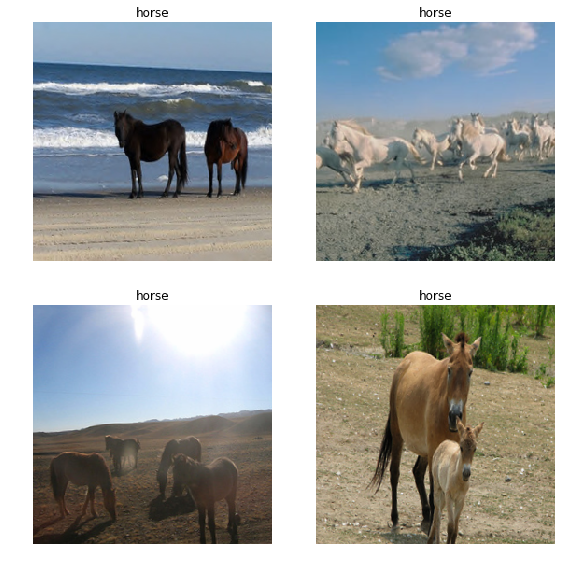

In [22]:
dataA.show_batch(rows=2)

In [ ]:
# ich bin mir sicher das wir irgendwann noch normalisieren wollen ^^
# print(dataA.normalize().one_batch())

# https://github.com/aitorzip/PyTorch-CycleGAN
# https://hardikbansal.github.io/CycleGANBlog/

In [39]:
## now we need to create our model
## create this block new and find out what it is dooing :-)
class ResNetBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.LeakyReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [42]:
# gerator takes an image of a horse and is gernating a zebra
# 1. get image and encode is
# 2. transform the image
# 3. decode image
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, nf=64, n_residual_blocks=9):
        super(Generator, self).__init__()
        
        #Initial convolution bloack
        model = [ nn.ReflectionPad2d(3), # its like normal padding but not with 0 :=) i should get at least the basics
                  nn.Conv2d(input_nc, 64, 7), # 64, 7 standard resenet architecture?
                  nn.InstanceNorm2d(64), # 
                  nn.LeakyReLU(inplace=True) # orignal nutzt er nur ReLU                        
        ]
        
#         Source; https://github.com/soumith/ganhackselu
#         5: Avoid Sparse Gradients: ReLU, MaxPool
#         the stability of the GAN game suffers if you have sparse gradients
#         LeakyReLU = good (in both G and D)
#         For Downsampling, use: Average Pooling, Conv2d + stride
#         For Upsampling, use: PixelShuffle, ConvTranspose2d + stride
#         PixelShuffle: https://arxiv.org/abs/1609.05158

        # Downsample
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            # muss noch aufgeraeumt werden als function
            model += [ nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(out_features),
                       nn.LeakyReLU(inplace=True) ]
            in_features = out_features
            out_features = out_features * 2
            
        # res block
        for _ in range(2):
            model += [ResNetBlock(in_features)]
            
        # Upsample
        out_features = in_features//2
        for _ in range(2):
            # muss noch aufgeraeumt werden als function
            model += [ nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(out_features),
                       nn.LeakyReLU(inplace=True) ]
            in_features = out_features
            out_features = out_features//2
            
        # Output layer
        model += [ nn.ReflectionPad2d(3),
                   nn.Conv2d(64, output_nc, 7),
                   nn.Tanh() ]
        
        self.model = nn.Sequential(*model)

        
    def forward(self, x):
        return self.model(x)


In [49]:
class Discriminator(nn.Module):
    #just a conv net, to check if we predicting 0 or 1 e.g. 0.0 - 0.2 for false and 0.8 - 1.2 for true
    # check if we can repace this with a better network which is pretrained :-) would be cool
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        
        # some convolutions :-)
        # refectore den scheiss und replace ihn komplett hoffenltich mit pretrained network
        model = [ nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                  nn.LeakyRelu(0.2, inplace=True) ]
        
        model += [ nn.Conv2d(64, 128, 4, stride=2, padding=1),
                   nn.InstanceNorm2d(128),
                   nn.LeakyReLU(0.2, inplace=True)]
        
        model += [ nn.Conv2d(128, 256, 4, stride=2, padding=1),
                   nn.InstanceNorm2d(256),
                   nn.LeakyReLU(0.2, inplace=True)]
        
        model += [ nn.Conv2d(256, 215, 4, stride=2, padding=1),
                   nn.InstanceNorm2d(512),
                   nn.LeakyReLU(0.2, inplace=True)]
        
        # output of our conf should be a 1x4 matrix so make the thing smaller
        model += [ nn.Conv2d(512, 1, 4, padding=1)]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        x = self.model(x)
        # get average of the ouput
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)